In [62]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, multilabel_confusion_matrix
from sklearn.metrics import auc, roc_curve
from sklearn.ensemble import RandomForestRegressor
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import scale, label_binarize
from scipy.stats import pearsonr

In [32]:
import pandas as pd  # provides interface for interacting with tabular data
import geopandas as gpd  # combines the capabilities of pandas and shapely for geospatial operations
from shapely.geometry import Point, Polygon, MultiPolygon  # for manipulating text data into geospatial shapes
from shapely import wkt  # stands for "well known text," allows for interchange across GIS programs
import rtree  # supports geospatial join
import os
import fnmatch
import numpy as np
import matplotlib.pyplot as plt
import descartes
import sys
import sklearn
from shapely.ops import nearest_points
from datetime import datetime as dt, date
sys.path.append('/Users/saraprice/Documents/NYU/Fall_2020/DS_GA_1001/final_project/wildfires-1001/code/functions/')
from gis_processing import *
from modeling_functions import *
import pickle

In [3]:
data_dir = '/Users/saraprice/Documents/NYU/Fall_2020/DS_GA_1001/final_project/wildfires-1001/data'
model_dir = '/Users/saraprice/Documents/NYU/Fall_2020/DS_GA_1001/final_project/wildfires-1001/models'

In [4]:
weather_rename_dict = pd.read_pickle(os.path.join(data_dir, 'clean_data/ERA_weather-data/ERA_rename_dictionary.pkl'))

In [5]:
target_df1 = pd.read_pickle(os.path.join(data_dir, 'clean_data/target_df_final_1123_newtargets_1.pkl'))
target_df2 = pd.read_pickle(os.path.join(data_dir, 'clean_data/target_df_final_1123_newtargets_2.pkl'))
target_df = target_df1.append(target_df2)
target_df.rename(columns = weather_rename_dict, inplace = True)

In [6]:
non_mod_cols = ['GRID_ID','month_id','MONTH','COUNTYFP','COUNTY_AREA', 'NAME','GRID_AREA','COUNTY_ARE','month_id_old_x','month_id_old_y',
                'geometry','Fire_area','total_fire_days','hist_p_time_1y','total_fire_days','hist_p_time_1y', 
                'hist_p_time_1m', 'month_id_old', 'YEAR']
Y_cols = ['Y_bin', 'Y_fire_count', 'Y_fire_area_prop', 'Y_fire_class_size','Y_bin_new_fire_month',
          'Y_max_new_fire_size_month','Y_count_new_fires_month']

## Linear Regression on Area Prop

In [93]:
train_data = target_df[(target_df['YEAR']>=1990) & (target_df['YEAR']<=2016)]
X_train = train_data.drop('YEAR', axis = 1)
for y in Y_cols + non_mod_cols:
    try:
        X_train.drop(y, inplace = True, axis =1)
    except:
        pass
Y_train_cont = train_data['Y_fire_area_prop']

In [94]:
test_data = target_df[target_df['YEAR']>2016]
X_test = test_data.drop('YEAR', axis = 1)
for y in Y_cols + non_mod_cols:
    try:
        X_test.drop(y, inplace = True, axis =1)
    except:
        pass
Y_test_cont = test_data['Y_fire_area_prop'] 

In [99]:
X_train_scaled = pd.DataFrame(scale(X_train), columns = X_train.columns)
X_test_scaled = scale(X_test)
Y_train_cont = np.where(Y_train_cont == 0, 0, np.sqrt(Y_train_cont))
Y_train_cont = Y_train_cont
Y_test_cont = np.where(Y_test_cont == 0, 0, np.sqrt(Y_test_cont))
Y_test_cont = Y_test_cont

In [100]:
np.unique(Y_train_cont)

array([0.        , 1.1204591 , 1.12623527, ..., 4.33138661, 4.41223389,
       4.44492069])

(array([3.8283e+04, 0.0000e+00, 2.8000e+01, 1.4900e+02, 4.7400e+02,
        9.1600e+02, 1.5560e+03, 1.0940e+03, 1.1900e+02, 1.7000e+01]),
 array([0.        , 0.44449207, 0.88898414, 1.33347621, 1.77796827,
        2.22246034, 2.66695241, 3.11144448, 3.55593655, 4.00042862,
        4.44492069]),
 <BarContainer object of 10 artists>)

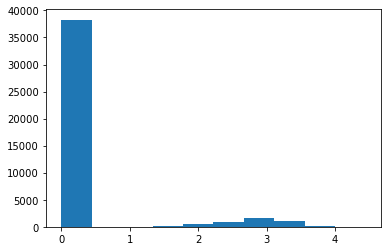

In [101]:
plt.hist(Y_train_cont)

### Get correlation with target variable

In [102]:
corr_w_target = []
for i in X_train.columns:
    rho, p = pearsonr(X_train[i], Y_train_cont)
    corr_w_target.append(rho)

corr_target_df = pd.DataFrame(np.column_stack([X_train.columns, corr_w_target]), columns = ['col', 'feature_importance'])
corr_target_df.sort_values('feature_importance', ascending = False)

,col,feature_importance
29,adj_fire_bcount,0.299151
73,hist_bin_no_leak_1m,0.256197
28,adj_fire_count,0.224849
62,hist_bin_1y,0.214752
74,hist_cl_size_no_leak_1m,0.203259
...,...,...
138,tot_prcp_12hrs_5y,-0.137689
137,tot_prcp_6hrs_5y,-0.137764
169,tot_prcp_6hrs_10y,-0.142538
170,tot_prcp_12hrs_10y,-0.142634


In [103]:
top_feats = {}
for i in np.arange(20, 45, 5):
    top_feats[i], corr_df = select_features_corr_imp(X_train, corr_target_df, 0.75, i)
    print(top_feats[i])

['adj_fire_bcount', 'hist_bin_no_leak_1m', 'adj_fire_count', 'hist_bin_1y', '2m_tmp_18hrs_5y', 'hist_cl_size_5y', 'hist_bin_10y', 'leaf_high_veg_0hrs', 'leaf_high_veg_6hrs', 'leaf_high_veg_18hrs', 'leaf_high_veg_12hrs', '2m_dewpoint_tmp_6hrs_10y', 'hist_fire_area_prop_10y', 'elev_range', 'V_wind_10m_18hrs_10y', 'leaf_low_veg_0hrs', 'leaf_low_veg_12hrs', 'leaf_low_veg_18hrs', 'leaf_low_veg_6hrs', 'hist_prop_area_fire_1m', 'U_wind_10m_0hrs']
['adj_fire_bcount', 'hist_bin_no_leak_1m', 'adj_fire_count', 'hist_bin_1y', '2m_tmp_18hrs_5y', 'hist_cl_size_5y', 'hist_bin_10y', 'leaf_high_veg_12hrs', 'leaf_high_veg_18hrs', 'leaf_high_veg_6hrs', 'leaf_high_veg_0hrs', '2m_dewpoint_tmp_6hrs_10y', 'hist_fire_area_prop_10y', 'elev_range', 'V_wind_10m_18hrs_10y', 'leaf_low_veg_0hrs', 'leaf_low_veg_12hrs', 'leaf_low_veg_18hrs', 'leaf_low_veg_6hrs', 'hist_prop_area_fire_1m', 'U_wind_10m_0hrs', 'elev_media', 'total_road_length', 'tot_area_fire_prev_1yr', 'V_wind_10m_0hrs', 'total_pl_length']
['adj_fire_bc

IndexError: list index out of range

In [104]:
X_train_scaled = pd.DataFrame(scale(X_train), columns = X_train.columns)
X_test_scaled = pd.DataFrame(scale(X_test), columns = X_test.columns)

#### Subset by out feature importance subset dictionary we created above

In [105]:
X_train_linR = {}
X_test_linR = {}
for i in list(top_feats.keys()):
    print(i)
    X_train_linR[i] = X_train_scaled[top_feats[i]]
    X_test_linR[i] = X_test_scaled[top_feats[i]]

20
25
30
35


In [106]:
#regularization hyperparam options
cs = [10**i for i in range(-4, 2)] 

### Linear Regression

In [107]:
### Fitting LR using diff regularization, number of features & feature selection method
linR = {}
R2 = {}
for i in list(top_feats.keys()):
    linR[i] = LinearRegression().fit(X_train_linR[i], Y_train_cont)
    R2[i] = linR[i].score(X_test_linR[i], Y_test_cont)
    print(R2[i])

0.21317125418753724
0.21054562153075684
0.21038955812311688
0.2126613171887204


### Ridge Regression

In [108]:
#regularization hyperparam options
alphas = [1/((2)*(10**i)) for i in range(-4, 2)] 

In [109]:
### Fitting LR using diff regularization, number of features & feature selection method
ridge_reg = {}
ridge_R2 = {}
for i in list(top_feats.keys()):
    ridge_reg[i] = {}
    ridge_R2[i] = {}
    for a in alphas:
        ridge_reg[i][a] = Ridge(alpha = a).fit(X_train_linR[i], Y_train_cont)
        ridge_R2[i][a] = ridge_reg[i][a].score(X_test_linR[i], Y_test_cont)
        print(ridge_R2[i][a])

0.2068294214063663
0.21254446178927477
0.21310910572439656
0.2131650457364187
0.21317063340760234
0.2131711921101963
0.20564481635443366
0.21011119358759733
0.21050314477242615
0.21054138419614388
0.21054519790143889
0.21054557916886685
0.20577967916119388
0.2100001423710669
0.21035201778481027
0.21038581951776503
0.21038918441845056
0.21038952075421047
0.20764121590594053
0.21274763275713615
0.2127748934257654
0.21270579800375033
0.21269728439944213
0.2126964150909425
